![DBC](Images/DBC.png)

# Scopus Metrics Scraper

**Introduction**

This notebook automates the process of retrieving bibliometric data from Scoups for a list of authors. It utilizes [pybliometrics](https://pybliometrics.readthedocs.io/en/stable/), a Python library that allows users to retrieve author and citation data from [Scopus](https://www.scopus.com/). It requires an API key (which can be obtained [here](https://dev.elsevier.com/)) and likely an InstToken (which can be obtained by emailing apisupport@elsevier.com).

**Setup**

1. Install the stable version of pybliometrics from PyPI:

    pip install pybliometrics

2. Upload a CSV with author names in the first column and Scopus ID's in the second column (no column names). Scopus ID's can be found in the URL of the author's Scopus profile. 

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import csv


Make sure pybiometrics is installed (I have to do this every time I run this notebook)

In [97]:
from pybliometrics.scopus import AbstractRetrieval, AuthorSearch, AuthorRetrieval, CitationOverview

Load in Scopus IDs for authors

In [98]:
# Modify this to match your uploaded author list CSV
input_author_csv = 'DBC-Investigators-ScopusID.csv'

output_data = 'Scoups_output_dbc.csv' 

ids= []
with open(input_author_csv, encoding ="utf-8-sig") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter =',')
    for row in csv_reader:
        if (len(row) == 2):
            ids.append([row[1]])

Retrieve the data for each author.

In [99]:
rows = []
# This list will contain all the ids of the documents by all authors in the list
doc_ids = []

for id in ids:
    au = AuthorRetrieval(int(id[0]))
    row = {'Name': au.given_name + ' ' + au.surname, 'Scholar ID': int(id[0]),
           'Citation Count': au.citation_count, 'Document Count': au.document_count, 
           'h-index': au.h_index, 'Publication Range': au.publication_range, 
           'Document IDs': au.get_document_eids(),'Affiliation': au.affiliation_current[0][5]}
    rows.append(row)

    for doc_eid in au.get_document_eids():
        doc_id = doc_eid[7:]               #must strip the first 7 symbols of the eid to be left with id
        if doc_id not in doc_ids:
            doc_ids.append(doc_id)


Write the data to the output CSV

In [100]:
# Specify the order of the data. These keys must match the names of the keys in the rows dictionary. 
keys = ['Name', 'Scholar ID', 'Citation Count', 'Document Count', 'h-index', 'Publication Range',  
        'Document IDs', 'Affiliation']

# This creates/opens the file with filename with the intention to write to the csv_file
# The encoding allows the characters to be properly written to the csv_file
with open(output_data, mode='w', encoding ="utf-8") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer = csv.DictWriter(csv_file, keys, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer.writeheader()
    dict_writer.writerows(rows)

Create citations/year bar chart. Pybiometric's CitationOverview takes a list of 1-25 IDs as a parameter. For some reason, it wasn't working when I used lists of 1 ID (calling CitationOverview for each ID), but worked when I included more than one ID in the list. See: https://pybliometrics.readthedocs.io/en/stable/classes/CitationOverview.html#pybliometrics.scopus.CitationOverview

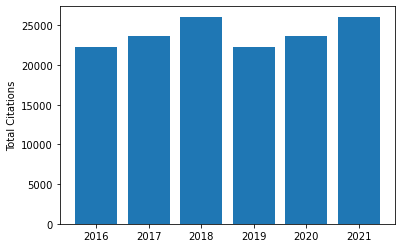

In [101]:
data = pd.DataFrame()

for i, id in enumerate(doc_ids):
    if i%25==0:
        if i!=0: # accounts for when i=0
            co1 = CitationOverview(id_list,start = 2016)    # I don't know why this only returns 3 years,
            co2 = CitationOverview(id_list,start = 2019)    # even if I set the end date later.
            for j, listOfTup in enumerate(co1.cc):
                cc_dict = dict(listOfTup)
                cc_dict.update(dict(co2.cc[j]))
                data = data.append(cc_dict, ignore_index=True)
        id_list = [id] # start new list when the current list is full
        
    else:
        id_list.append(id)
        
        
# Add a totals column
data.loc['Total']= data.sum()
    
# Select the last row (totals) 
data_total = data.iloc[-1:]

# Create barplot
years = list(data.columns)
cites = data_total.values.tolist()[0]
plt.bar(years, cites )
plt.ylabel('Total Citations')

# !!! Modify this - name the output PDF file
plt.savefig("citations.pdf")

